Instaluję potrzebne biblioteki, będę trzymał je w jednym miejscu na samej górze.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [20]:
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Pobrałem dane, które posłużą mi do oszacowania czy ktoś będzie miał problem ze splatą zadłużenia.

Opis danych:
    person_age - wiek
    person_income - roczny dochód
    person_home_ownership - czy jest to właściel domu
    person_emp_length - długość zatrudnienia
    loan_intent - zamiar pożyczki
    loan_grade - stopień kredytu
    loan_amnt - kwota pożyczki
    loan_int_rate - stopa procentowa
    loan_status - status kredytu (Będzie to nasz y - 1 oznacza nie spłacenie, 0 spłatę kredytu)
    loan_percent_income - procent dochodu
    cb_person_default_on_file - historyczny kredyt
    cb_preson_cred_hist_length - długość historii kredytowej

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


Zauważyłem, że w kolumnie: "person_emp_length" - są wartości Null jest ich 895, oraz w kolumnie: "loan_int_rate" - również są wartości Null jest ich 3116. Mam dwa rozwiązania, 1 jest to wyrzucenie tych wierszy gdzie znajdują się nulle, lecz jest ich aż prawie 10% z racji tego zastąpienie tego wartościa mediany będzie lepszym wyborem. Jest to o wiele lepsze rozwiązanie od średniej ponieważ nie jest aż tak wrażliwa na wartości odstające.

In [22]:
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].median())
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Ponieważ będę wykorzystywał 3 modele a mianowicie: XGBoost, RadomForest oraz RegresjęLiniową, chciałbym aby wszystkie wartości były numeryczne. Sprawdzę czy jest dużo wartości które nie są numeryczne oraz ile ich jest unikalnych, jeżeli będzie dużo zrobię przedziały jeżeli nie to po prostu zamienie je na numeryczne za pomocą funkcji pd.get_dummies().

In [23]:
print(df['person_home_ownership'].unique())
print(df['loan_intent'].unique())
print(df['cb_person_default_on_file'].unique())
print(df['loan_grade'].unique())

['RENT' 'OWN' 'MORTGAGE' 'OTHER']
['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
['Y' 'N']
['D' 'B' 'C' 'A' 'E' 'F' 'G']


Jeżeli zastosowałbym funkcję pd.get_dumies() uzyskałbym 17 nowych kolumn co nie jest dużą ilością, na którą się godzę wiec skorzystam z tej funkcji.

In [24]:
df_num = pd.get_dummies(df, columns=['person_home_ownership','loan_intent','cb_person_default_on_file','loan_grade'])
df_num.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,22,59000,123.0,35000,16.02,1,0.59,3,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False
1,21,9600,5.0,1000,11.14,0,0.10,2,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,3,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False


Teraz będę sprawdzał korelację miedzy zmiennymi, zmienne które będą za bardzo ze sobą korelować będę musiał wyrzucić z modelu.

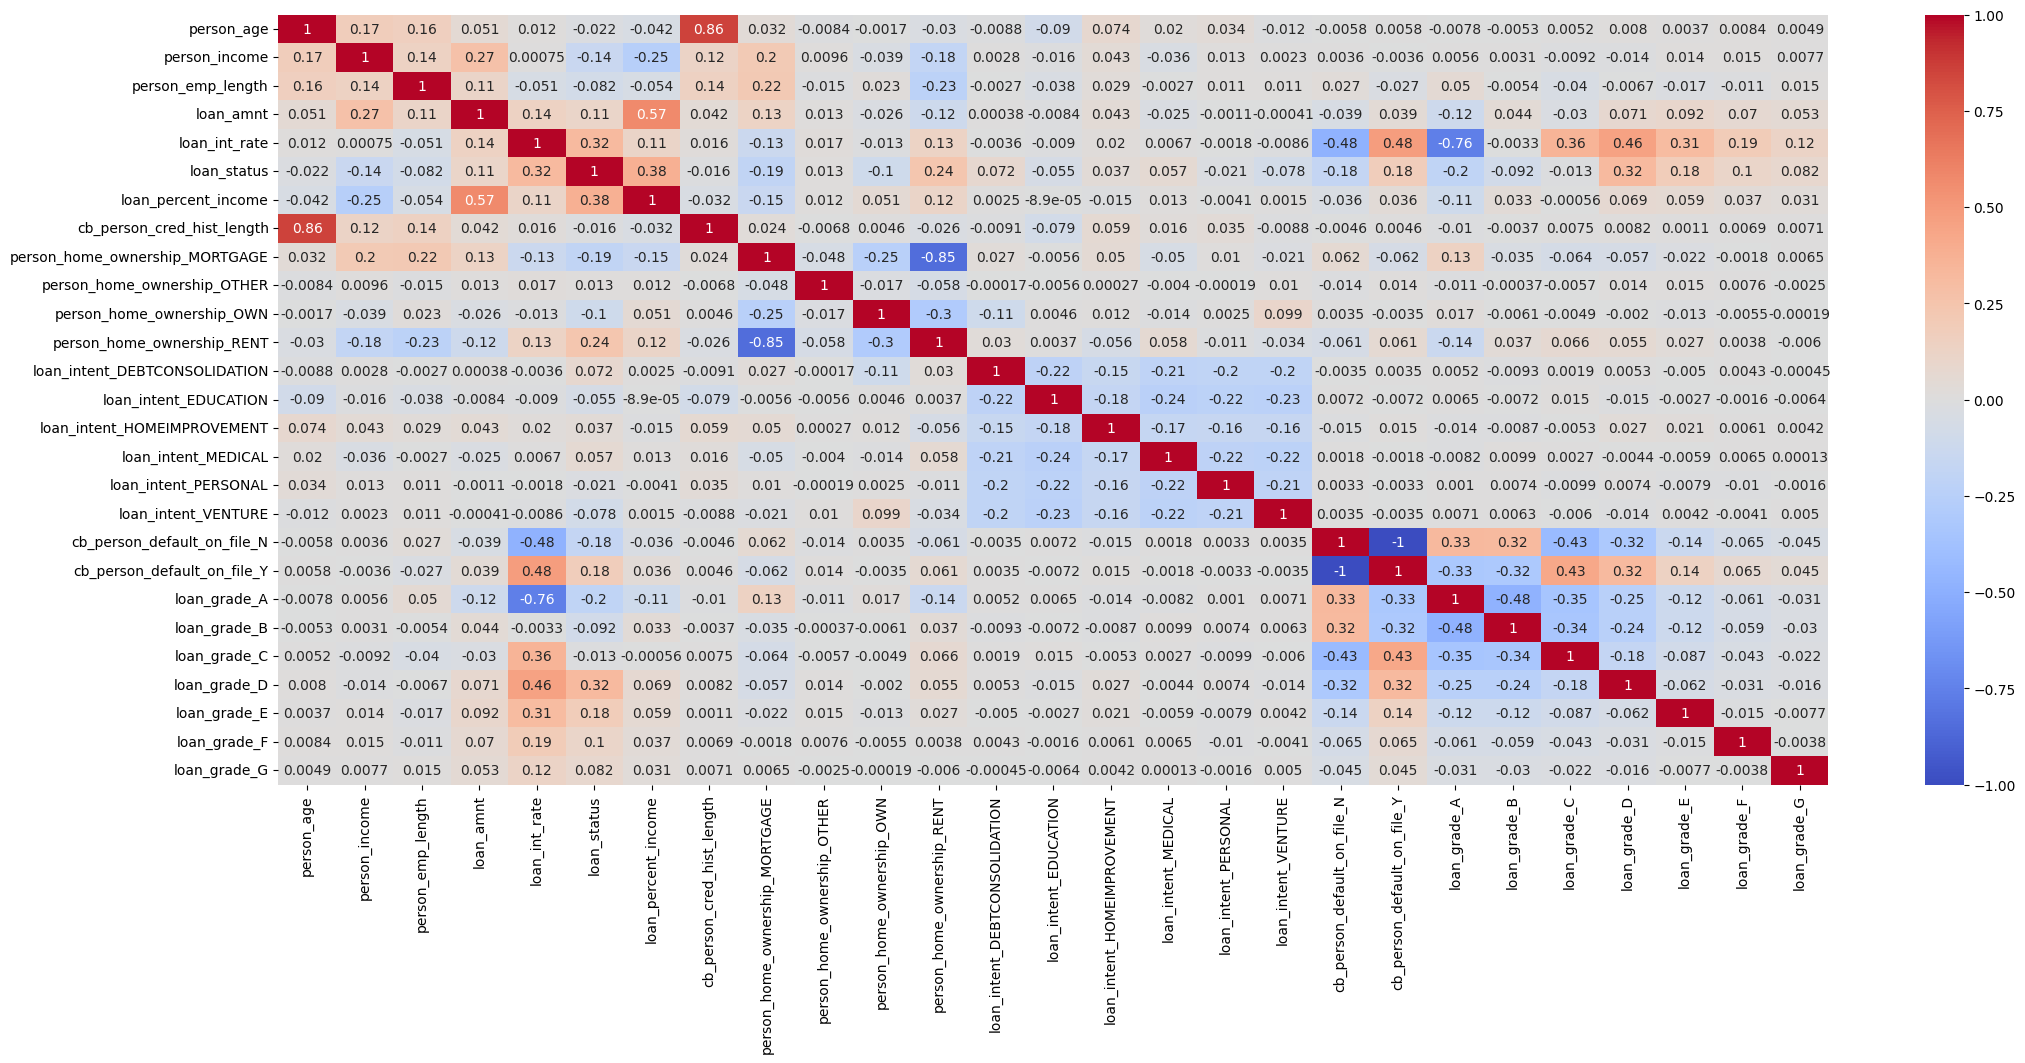

In [25]:
correlation = df_num.corr()
plt.figure(figsize=(25,10))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.show()

Muszę wyrzucić kolumnę: 'cb_person_cred_hist_length' - za duża korelacja z 'person_age', 'loan_int_rate' - za duża korelacja z 'loan_amnt', 'person_home_ownership_MORTAGE' - za duża korelacja z 'person_home_ownership_RENT', 'cb_person_default_on_file_N' za duża korelacja z 'cb_person_default_on_file_Y'.

In [26]:
df_num = df_num.drop(columns=['cb_person_cred_hist_length','loan_int_rate','person_home_ownership_MORTGAGE','cb_person_default_on_file_N'], axis=1)
df_num.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_status,loan_percent_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,22,59000,123.0,35000,1,0.59,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False
1,21,9600,5.0,1000,0,0.10,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
2,25,9600,1.0,5500,1,0.57,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
3,23,65500,4.0,35000,1,0.53,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False
4,24,54400,8.0,35000,1,0.55,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False


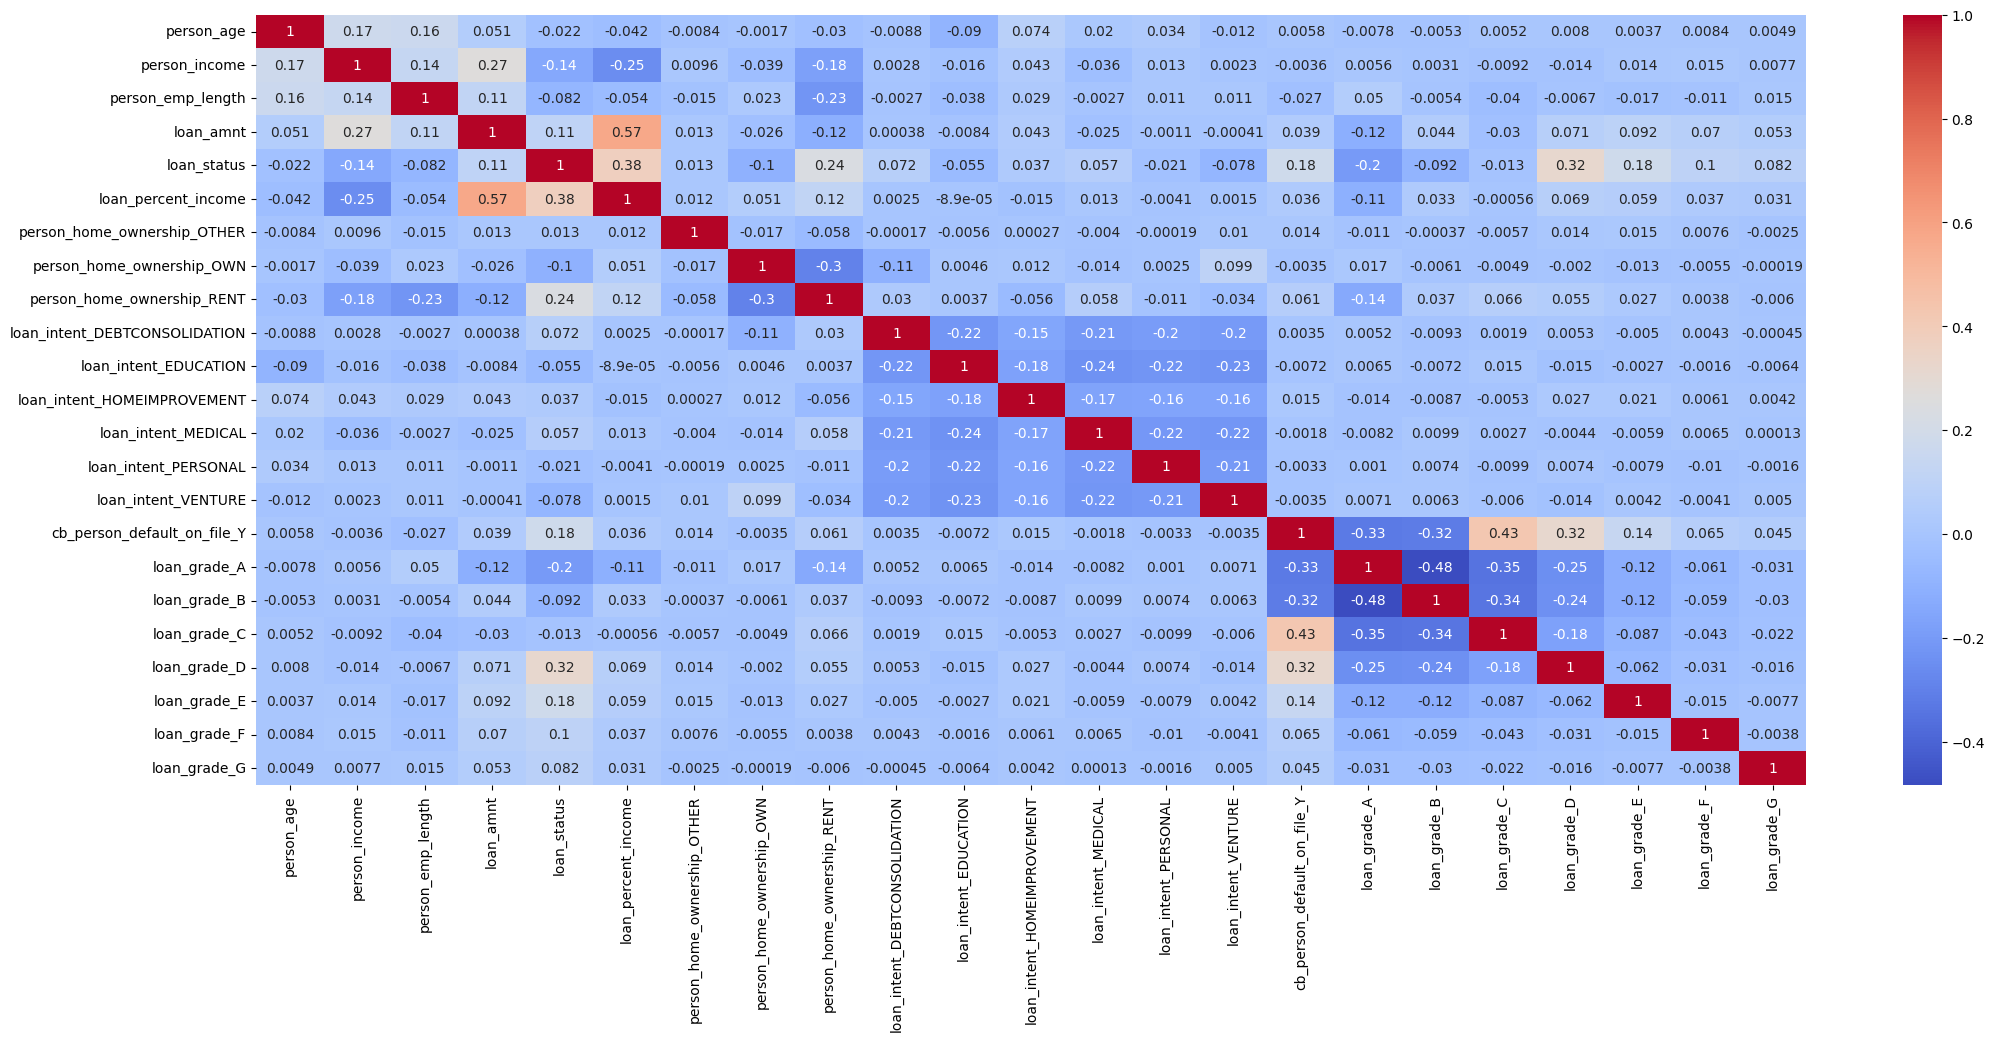

In [27]:
correlation = df_num.corr()
plt.figure(figsize=(25,10))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.show()

Teraz widzę że wygląda to o wiele lepiej niż poprzednio i tak to może zostać. Już teraz mogę utworzyć Y na którym będę działał.

In [28]:
X = df_num.drop("loan_status", axis=1)
y = df_num['loan_status']
X.head()
y.head()

0    1
1    0
2    1
3    1
4    1
Name: loan_status, dtype: int64

Sprawdzam czy trzeba zeskalować dane

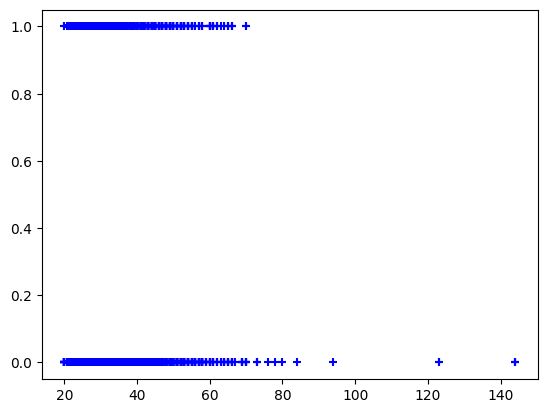

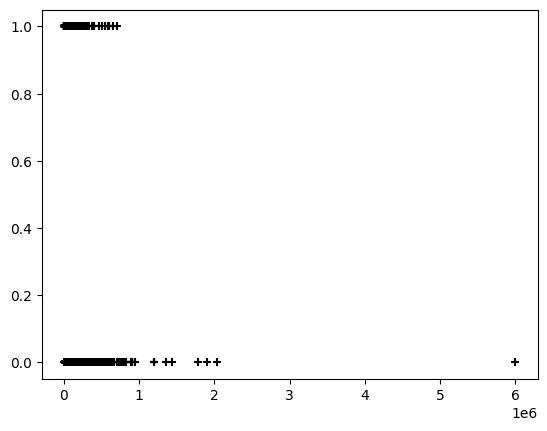

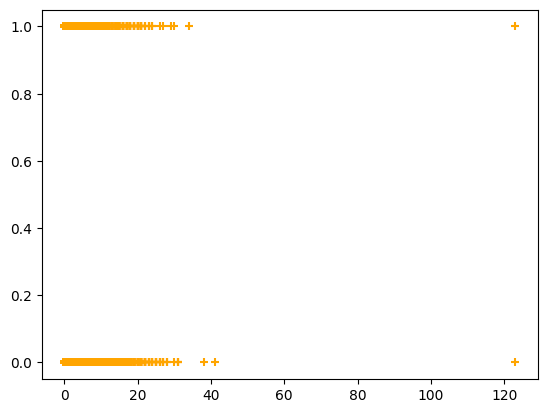

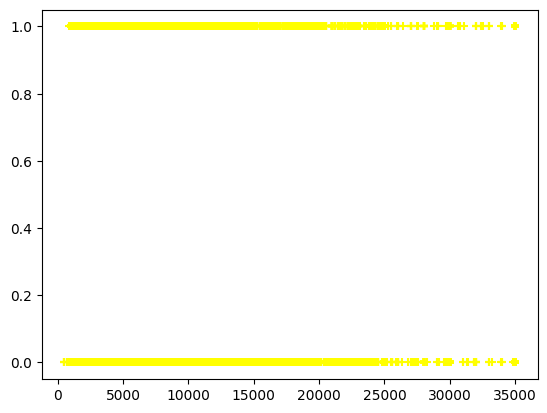

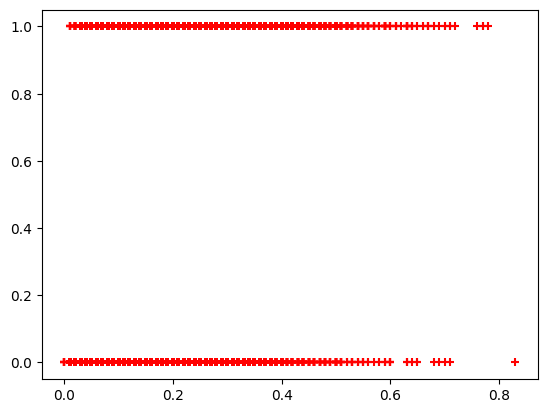

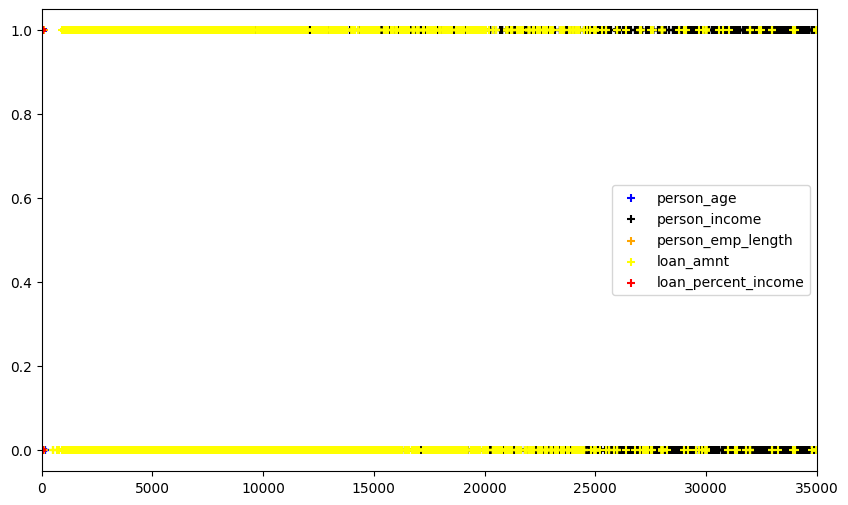

In [29]:
plt.scatter(X["person_age"],y,marker="+",color='blue')
plt.show()

plt.scatter(X["person_income"],y,marker="+",color='black')
plt.show()

plt.scatter(X["person_emp_length"],y,marker="+",color='orange')
plt.show()

plt.scatter(X["loan_amnt"],y,marker="+",color='yellow')
plt.show()

plt.scatter(X["loan_percent_income"],y,marker="+",color='red')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X["person_age"],y,marker="+",color='blue', label="person_age")
plt.scatter(X["person_income"],y,marker="+",color='black', label="person_income")
plt.scatter(X["person_emp_length"],y,marker="+",color='orange', label="person_emp_length")
plt.scatter(X["loan_amnt"],y,marker="+",color='yellow',label="loan_amnt")
plt.scatter(X["loan_percent_income"],y,marker="+",color='red',label="loan_percent_income")
plt.xlim(0,max(X["loan_amnt"]))
plt.legend()
plt.show()

Widzę jak wielkie jest rozproszenie pomiędzy danymi, aby model lepiej działał należy zatem zescalować dane.

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X=pd.DataFrame(X_scaled, columns=[col for col in X.columns])
X.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_percent_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,-0.903374,-0.114143,28.926614,4.019404,3.931411,-0.057402,-0.293499,0.990500,-0.436388,-0.496967,-0.352723,-0.478548,2.213885,-0.461414,2.161294,-0.703041,-0.687208,-0.497207,2.825842,-0.174614,-0.086325,-0.044364
1,-1.060904,-0.911147,0.056763,-1.358650,-0.657458,-0.057402,3.407161,-1.009591,-0.436388,2.012205,-0.352723,-0.478548,-0.451695,-0.461414,-0.462686,-0.703041,1.455163,-0.497207,-0.353877,-0.174614,-0.086325,-0.044364
2,-0.430783,-0.911147,-0.921876,-0.646849,3.744110,-0.057402,-0.293499,-1.009591,-0.436388,-0.496967,-0.352723,2.089656,-0.451695,-0.461414,-0.462686,-0.703041,-0.687208,2.011234,-0.353877,-0.174614,-0.086325,-0.044364
3,-0.745843,-0.009274,-0.187897,4.019404,3.369508,-0.057402,-0.293499,0.990500,-0.436388,-0.496967,-0.352723,2.089656,-0.451695,-0.461414,-0.462686,-0.703041,-0.687208,2.011234,-0.353877,-0.174614,-0.086325,-0.044364
4,-0.588313,-0.188358,0.790742,4.019404,3.556809,-0.057402,-0.293499,0.990500,-0.436388,-0.496967,-0.352723,2.089656,-0.451695,-0.461414,2.161294,-0.703041,-0.687208,2.011234,-0.353877,-0.174614,-0.086325,-0.044364


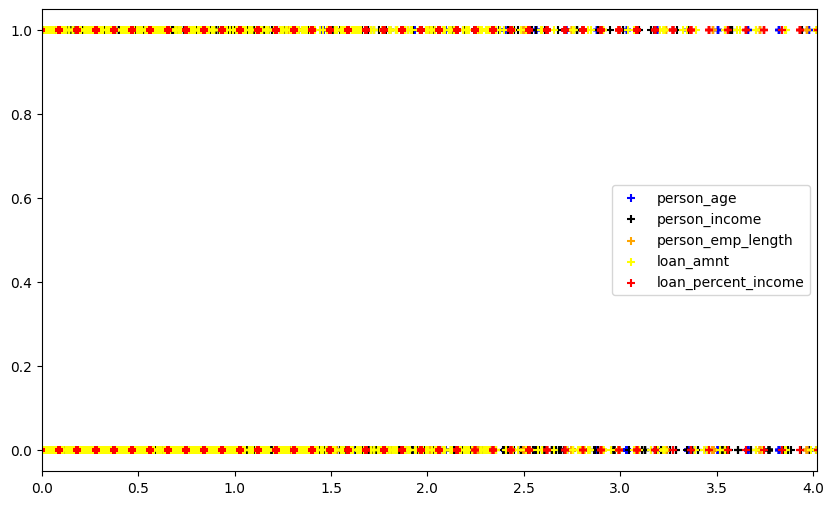

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(X["person_age"],y,marker="+",color='blue', label="person_age")
plt.scatter(X["person_income"],y,marker="+",color='black', label="person_income")
plt.scatter(X["person_emp_length"],y,marker="+",color='orange', label="person_emp_length")
plt.scatter(X["loan_amnt"],y,marker="+",color='yellow',label="loan_amnt")
plt.scatter(X["loan_percent_income"],y,marker="+",color='red',label="loan_percent_income")
plt.xlim(0,max(X["loan_amnt"]))
plt.legend()
plt.show()

Teraz widzę że wyglada to już o wiele lepiej niż poprzednio. Teraz czas zająć się podzieleniem danych na dadne trenujące, testowe oraz modelami i porównywaniem wyników.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(26064, 22)
(6517, 22)


In [42]:
model_forest = RandomForestClassifier(n_estimators=100)
model_regresja = LogisticRegression(random_state=42, max_iter=100)
model_XGBoost = XGBClassifier(random_state=42, n_jobs=-1)

model_forest.fit(X_train,y_train)
class_report_forest = classification_report(y_test, model_forest.predict(X_test), output_dict=True)
print("Radom Forest: " + str(class_report_forest["weighted avg"]["precision"]))

model_regresja.fit(X_train,y_train)
class_report_regresja = classification_report(y_test, model_regresja.predict(X_test), output_dict=True)
print("Regresja: " + str(class_report_regresja["weighted avg"]["precision"]))

model_XGBoost.fit(X_train,y_train)
class_report_XGBoost = classification_report(y_test, model_XGBoost.predict(X_test), output_dict=True)
print("XGBoost: " + str(class_report_XGBoost["weighted avg"]["precision"]))

Radom Forest: 0.9325908637955624
Regresja: 0.8536503908219559
XGBoost: 0.9336153746057324


Najlepiej wyszedł model XGBoost, wybrałem te 3 ponieważ ważne jest aby były łatwo "wytłumaczalne" w takich bankowych decyzjach. Ponieważ jest to XGBoost nie trzeba robić optymalizacji dopasowania danych. Teraz sprawdzę confusion matrix oraz które zmienne najbardziej wpływały na decyzję.

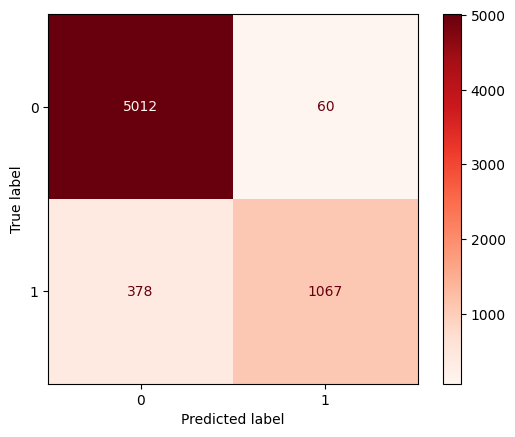

In [44]:
y_pred = model_XGBoost.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot(cmap="Reds")
plt.show()

Z tego co widzę wychodzi to całkiem dobrze fałszywych pozytywnych jest 378 co wypadałoby tutaj poprawić, lecz gorsza sytuacja byłaby gdyby więcej było fałszywych zer co oznaczałoby, że model nie wyłapuje kiedy ktoś nie spłaci kredytu.

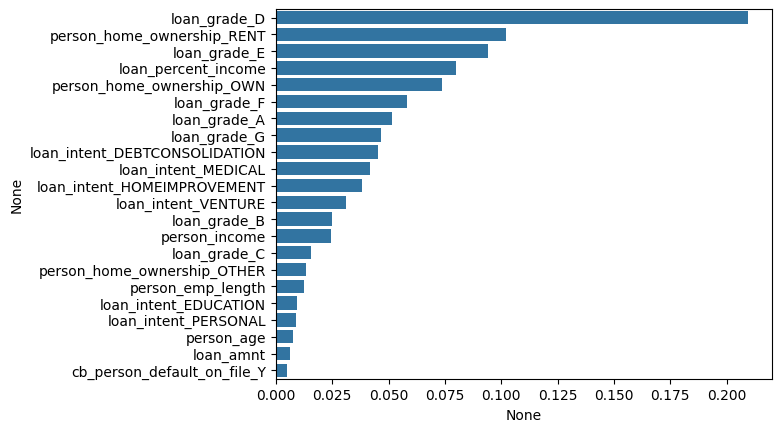

In [48]:
waznosc = pd.Series(model_XGBoost.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=waznosc,y=waznosc.index)
plt.show()

Z tego co widzę największą ważność ma kolumna "loan-grade_D" następnie "person_home_ownership_RENT" itd. Na tym zakończę moją analizę, w przyszłym czasie warto zastanowić sie nad innymi modelami które również są łatwo "wytłumaczalne" a jednak lepiej pasują do tego tematu.